# Riconoscimento degli Aruco Markers

In questo foglio andiamo a comprendere come riconoscere gli Aruco Markers. Per chi non sapesse di cosa stiamo parlando metto un'immagine qui sotto di un Aruco Marker.
Esatto, sono simili ai QR code, ma hanno una feature in più molto utile, ci forniscono anche l'informazione della posizione spaziale rispetto alla camera, molto utile per tracciare il percorso.

*inserire immagine AM*

Mettiamoci quindi in una cartella ed iniziamo il lavoro.

In primis ci serve creare un file con delle impostazioni, per salvare queste informazioni utilizzeremo il formato <font color="red">yaml</font>.

Il contenuto di questo file è presto spiegato:
<ul>
    <li><i><font color="green">aruco_dictionary</font></i> indica il tipo di Aruco che utilizzeremo, nel mio caso 6x6 da 50 elementi, ma voi potete usare quelli che volete basta che ne tenete conto qui.</li>
    <li><i><font color="green">aruco_markerLength</font></i> indica la larghezza del Marker (quadrato) nella realtà in metri, quindi una volta stampato, questo serve per il calcolo della distanza.</li>
    <li><i><font color="green">aruco_canvasResolution</font></i> indica la risoluzione della finestra in cui vorremo vedere l'immagine con i marker selezionati.</li>
</ul>

In [31]:
import yaml
settings = {
            'aruco_dictionary' : 'DICT_6X6_50',
            'aruco_markerLength' : 0.066,
            'aruco_canvasResolution' : (800, 800) #se usate PiCamera mettene 640, 480
            }

with open(r'part3/aruco_settings.yaml', 'w') as file:
    _ = yaml.dump(settings, file)

In questo file potremmo aggiungere anche il "Database" dei cartelli stradali, ovvero un'ulteriore voce <font color="green">aruco_streetSign</font> con un dizionario che associa all'id del marker un cartello stradale.

In [32]:
aruco_streetSign = {'aruco_streetSign' : {
                      0 : ['STOP', 'Stop'],
                      1 : ['IN', 'Incrocio'],
                      2 : ['ATTC', 'Attraversamento Cheems'],
                      3 : ['SEM', 'Semaforo']
                    }
                   }
with open(r'part3/aruco_settings.yaml', 'a') as file:
    _ = yaml.dump(aruco_streetSign, file)

Ogni cartello l'abbiamo trattato come una coppia di un codice che riutilizzeremo nella guida autonoma ed un testo Human-Friendly.

Ci dovremmo trovare davanti un file di questo genere:

*inserire screen file yaml*

Iniziamo ora con la stesura del codice vero e proprio, creiamo una classe che conterrà tutte le funzioni necessarie per riconoscere i markers.

In [16]:
#importiamo le librerie necessarie
import cv2
import numpy as np
import math
import yaml
from pkg_resources import resource_string
import matplotlib.pyplot as plt

Successivamente scriverò le funzioni in blocchi singoli ma andranno chiaramente inserite nella classe.

In [22]:
#creiamo la classe ArucoDetector ed il suo costruttore __init__
class ArucoDetector:
    def __init__(self, cam_matrix, dist_coeff): #cam_matrix e dist_coeff sono variabili di cui abbiamo discusso nella parte 1
        #carichiamo le informazioni salvate nello YAML
        file = open('part3/aruco_settings.yaml')
        self.settings = yaml.full_load(file)
        #lista di tutti i possibili dizionari di aruco markers
        self.arucoDictionary = {
            "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
            "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
            "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
            "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
            "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
            "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
            "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
            "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
            "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
            "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
            "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
            "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
            "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
            "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
            "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
            "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
            "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
            "DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
            "DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
            "DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
            "DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
        }.get(self.settings['aruco_dictionary'], 'ERROR')
        #se c'è un errore nella richiesta del dizionario nelle settings
        if(self.arucoDictionary == 'ERROR'):
            print('Dizionario definito nell aruco_settings non esistente (DEFAULT: DICT_6X6_50)\n')
            self.arucoDictionary = cv2.aruco.DICT_6X6_50
        #prendo la lista dei cartelli stradali con equivalente codice aruco
        self.streetSign = self.settings['aruco_streetSign']
        #prendo il dizionario dei simboli aruco definitivi nelle settings
        self.dict = cv2.aruco.getPredefinedDictionary(self.arucoDictionary)
        #qua posso definire paramtri personalizzati, per ora vanno bene quelli standard
        self.params = cv2.aruco.DetectorParameters()
        self.cam_matrix = cam_matrix
        self.dist_coeff = dist_coeff
        self.corners = None
        self.ids = None
        self.rejected = None
        self.rvec = None
        self.tvec = None
        #lunghezza di un lato di un marker nelle dimensioni reali in metri
        self.markerLength = self.settings['aruco_markerLength']

Sfruttiamo <font color="red">undistort</font> per effetuare una proiettività (<a href="https://www.mat.uniroma2.it/~marini/Geometria_Proiettiva.pdf#page=16">link</a>) che mappa il la realtà 3-dimensionale allo schermo 2-dimensionale.

In [ ]:
def undistort(self, raw_image):
    #annullare gli effetti di curvatura della camera
    image = cv2.undistort(raw_image, self.cam_matrix, self.dist_coeff, None, self.cam_matrix)
    return image

Dato un frame (immagine) ottengo un'analisi dell'elenco e delle posizioni di tutti i marker presenti.

In [ ]:
def frameDetector(self, image):
    try:
        #funzione presente in cv2 per il riconoscimento degli aruco markers
        (self.corners, self.ids, self.rejected) = cv2.aruco.detectMarkers(image, self.dict, parameters=self.params)
        for id in self.ids:
            try:
                #peschiamo a DB il cartello corrispondente all'id
                descr_cartello = self.streetSign[id[0]][1]
                print(descr_cartello)
                print("Trovato l'id {0} che equivale al cartello {1}\n".format(id[0], descr_cartello))
            except:
                #se l'id non è presente a sistema
                print("L'id {0} trovato non equivale a nessun cartello a DB\n".format(id[0]))
        print("[INFO] Trovati {:d} aruco\n".format(len(self.ids)))
    except:
        print("[ERRORE] Impossibile riconoscere i markers\n")
    return self.corners

<p>Questa funzione mi restituisce le cooridnate del centro del marker nel sistema di rifermineto centrato nella camera.</p>
<p>Le coordinate dei vertici del marker sono (-markerLength/2, markerLength/2, 0), (markerLength/2, markerLength/2, 0), (markerLength/2, -markerLength/2, 0), (-markerLength/2, -markerLength/2, 0)</p>

In [ ]:
def estimatePoseMarkers(self):
    self.rvec, self.tvec, _ = cv2.aruco.estimatePoseSingleMarkers(self.corners, self.markerLength, self.cam_matrix, self.dist_coeff)
    return self.rvec, self.tvec

Programmiamo la trasformazione di Rodrigues che ci permette di trasformare un vettore di rotazione in una matrice di rotazione, più utile per i conti.
<a href="https://courses.cs.duke.edu/fall13/compsci527/notes/rodrigues.pdf">Link ad un PDF che spiega la formula</a>

In [ ]:
def rodrigues(self, r):
    theta = np.linalg.norm(r)
    u = np.array(r / theta)
    cross_u = np.array([[0,-u[2],u[1]],[u[2],0,-u[0]],[-u[1],u[0],0]])
    R = np.array(np.eye(3)*math.cos(theta) + (1-math.cos(theta))*np.matmul(u,u.T) + cross_u*math.sin(theta))
    return R

Disegnamo un rettangolo attorno ai marker, a mano questo codice disegna i sementi tra i punti definiti in corners

In [ ]:
def drawDetectedMarkers(self, image):
    return cv2.aruco.drawDetectedMarkers(image, self.corners)

<p>Disegnamo i sistemi di riferimento centrati nel cetro dei vari marker.</p>
<p>rvec mi da la distanza dalla camera al centro dei marker.</p>
<p>tvec mi da una rotazione del marker.</p>
<p>markerLegnth mi da la lunghezza vera del lato del marker.</p>
<p>Questi dati mi permettono di definire le coordinate 3D del centro e dei corner, a quel punto basta definire il piano passante per i 4 punti e si ha il sistema di riferimento. [per i puristi, per 4 non è detto che passi un piano, ma in questo caso ne abbiamo la certezza essendo 4 punti che definiscono una figura piana]</p>

In [ ]:
def drawAxis(self, image):
    try:
        for i in range(len(self.ids)):
            image = cv2.drawFrameAxes(image, self.cam_matrix, self.dist_coeff, self.rvec[i], self.tvec[i], self.markerLength/2)
        return image
    except:
        print("[ERRORE] Non ci sono markers di cui calcolare gli assi")
        return image

Aggiungiamo una funzione che ci stampa l'immagine finita ed una che chiude l'applicazione.

In [ ]:
def printImage(self, image):
    comboBig = cv2.resize(image, self.settings['aruco_canvasResolution'])
    plt.imshow(image)
    plt.show()
def close(self):
    cv2.destroyAllWindows()

Abbiamo terminato la classe, la riporto qui da compilare tutta insieme così da utilizzarla per i test.

In [35]:
import cv2
import numpy as np
import math
import yaml
from pkg_resources import resource_string
import matplotlib.pyplot as plt

class ArucoDetector:

    def __init__(self, cam_matrix, dist_coeff):
        file = open("part3/aruco_settings.yaml", "r")
        self.settings = yaml.full_load(file)
        self.arucoDictionary = {
            "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
            "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
            "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
            "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
            "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
            "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
            "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
            "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
            "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
            "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
            "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
            "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
            "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
            "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
            "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
            "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
            "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
            "DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
            "DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
            "DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
            "DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
        }.get(self.settings['aruco_dictionary'], 'ERROR')
        if(self.arucoDictionary == 'ERROR'):
            print('Dizionario definito nell aruco_settings non esistente (DEFAULT: DICT_6X6_50)\n')
            self.arucoDictionary = cv2.aruco.DICT_6X6_50
        self.streetSign = self.settings['aruco_streetSign']
        self.dict = cv2.aruco.getPredefinedDictionary(self.arucoDictionary)
        self.params = cv2.aruco.DetectorParameters()
        self.cam_matrix = cam_matrix
        self.dist_coeff = dist_coeff
        self.corners = None
        self.ids = None
        self.rejected = None
        self.rvec = None
        self.tvec = None
        self.markerLength = self.settings['aruco_markerLength']

    def undistort(self, raw_image):
        image = cv2.undistort(raw_image, self.cam_matrix, self.dist_coeff, None, self.cam_matrix)
        return image

    def frameDetector(self, image):
        try:
            (self.corners, self.ids, self.rejected) = cv2.aruco.detectMarkers(image, self.dict, parameters=self.params)
            for id in self.ids:
                try:
                    descr_cartello = self.streetSign[id[0]][1]
                    print(descr_cartello)
                    print("Trovato l'id {0} che equivale al cartello {1}\n".format(id[0], descr_cartello))
                except:
                    print("L'id {0} trovato non equivale a nessun cartello a DB\n".format(id[0]))
            print("[INFO] Trovati {:d} aruco\n".format(len(self.ids)))
        except:
            print("[ERRORE] Impossibile riconoscere i markers\n")
        return self.corners
    
    def estimatePoseMarkers(self):
        self.rvec, self.tvec, _ = cv2.aruco.estimatePoseSingleMarkers(self.corners, self.markerLength, self.cam_matrix, self.dist_coeff)
        return self.rvec, self.tvec

    def rodrigues(self, r):
        theta = np.linalg.norm(r)
        u = np.array(r / theta)
        cross_u = np.array([[0,-u[2],u[1]],[u[2],0,-u[0]],[-u[1],u[0],0]])
        R = np.array(np.eye(3)*math.cos(theta) + (1-math.cos(theta))*np.matmul(u,u.T) + cross_u*math.sin(theta))
        return R

    def drawDetectedMarkers(self, image):
        return cv2.aruco.drawDetectedMarkers(image, self.corners)

    def drawAxis(self, image):
        #try:
        for i in range(len(self.ids)):
            image = cv2.drawFrameAxes(image, self.cam_matrix, self.dist_coeff, self.rvec[i], self.tvec[i], self.markerLength/2)
        return image
        #except:
        #    print("[ERRORE] Non ci sono markers di cui calcolare gli assi")
        #    return image

    def printImage(self, image):
        comboBig = cv2.resize(image, self.settings['aruco_canvasResolution'])
        plt.imshow(image)
        plt.show()

    def close(self):
        cv2.destroyAllWindows()

Ora dobbiamo programmare una pipeline che a partire da un'immagine (un frame che può provenire dalla fonte video che preferite), analizza e restituisce id e posizioni degli aruco markers.

Prima di tutto importiamo la calibrazione effettuata nella Parte 1 e creiamo un'istanza della classe sopra costruita.

In [36]:
file = open("part1/FinalCalibration.yml", "r")
calibration_data = yaml.load(file, Loader=yaml.UnsafeLoader)
cam_matrix = calibration_data['camera_matrix']
dist_coeff = calibration_data['distortion_coefficient']

detector = ArucoDetector(cam_matrix, dist_coeff)

Scriviamo ora l'ordine in cui devono essere effettuate le analisi dell'immagine.
Io utilizzo un'immagine di prova, voi potete ricevere il frame da qualsiasi flusso video.

In [39]:
raw_image = cv2.imread('part3/img/prova.jpg')
#correggo la curvatura derivante dalla camera
image = detector.undistort(raw_image)
#calcolo le coordinate dei vertici dei quadrati
corner = detector.frameDetector(image)
#calcolo il vettore distanza dalla camera e la rotazione rispetto ad essa per ogni aruco marker
rvec, tvec = detector.estimatePoseMarkers()
#distanza dal marker numero 0 è pari a tvec[0][0][2] nella stessa unità di misura del aruco_markerLength in aruco_settings.yaml
#stampo sull'immagine i rettangoli intorno ai marker
image = detector.drawDetectedMarkers(image)
#stampo sull'immagine gli assi centrati
image = detector.drawAxis(image)

L'id 10 trovato non equivale a nessun cartello a DB

L'id 5 trovato non equivale a nessun cartello a DB

Incrocio
Trovato l'id 1 che equivale al cartello Incrocio

[INFO] Trovati 3 aruco



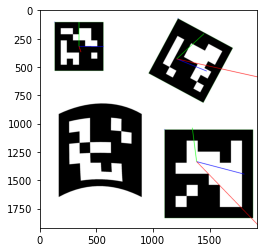

In [40]:
#per finire mostro l'immagine a schermo
#notiamo come l'immagine distorta non venga trovata mentre le eltre tre vengono sengalate
detector.printImage(image)